In [123]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter, ControlledGate, Gate
from qiskit.extensions import UnitaryGate
from qiskit.converters import circuit_to_gate

Dihydrogen Molecule (Electronic Hamiltonian):

In [124]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()
print(diHydro_prob)

In [125]:
# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals
print(coefficients.alpha)

Polynomial Tensor
 "+-":
[[-1.25633907e+00 -1.37083854e-17]
 [-6.07732712e-17 -4.71896007e-01]]
 "++--":
[[[[6.75710155e-01 1.69253442e-16]
   [1.56722377e-16 1.80931200e-01]]

  [[4.84650299e-17 1.80931200e-01]
   [6.64581730e-01 3.79897400e-16]]]


 [[[1.01440795e-16 6.64581730e-01]
   [1.80931200e-01 4.71502663e-17]]

  [[1.80931200e-01 3.78920172e-16]
   [6.59828421e-17 6.98573723e-01]]]]


In [126]:
# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op()
print(sq_h2_op)

# This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211568 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211568 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.3492868613660089 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.3492868613660089 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211568 * ( +_2 +_0 -_1 -_3 )
+ 0.0904655

In [127]:
# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)
print(qubit_h2_Ham)
#print(qubit_h2_Ham[0])

#2 * qubit_h2_Ham

-0.8105479805373275 * IIII
+ 0.1721839326191556 * IIIZ
- 0.2257534922240239 * IIZI
+ 0.17218393261915554 * IZII
- 0.2257534922240239 * ZIII
+ 0.12091263261776629 * IIZZ
+ 0.16892753870087907 * IZIZ
+ 0.04523279994605784 * YYYY
+ 0.04523279994605784 * XXYY
+ 0.04523279994605784 * YYXX
+ 0.04523279994605784 * XXXX
+ 0.16614543256382414 * ZIIZ
+ 0.16614543256382414 * IZZI
+ 0.17464343068300445 * ZIZI
+ 0.12091263261776629 * ZZII


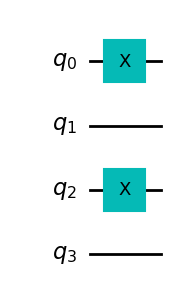

In [128]:
# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

initial_state = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

initial_state_copy = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

initial_state_width = initial_state.width()

# Draw the initial state to evolve:

initial_state.draw('mpl')
#print(initial_state_width)

In [129]:
# Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

exp_summand = list()
evo_time_range = np.arange(0, 20, 0.1)
evo_time = Parameter('t')

for i in range(0, len(qubit_h2_Ham)):
    exp_summand.append(PauliEvolutionGate(qubit_h2_Ham[i], time=evo_time))

In [130]:
# Obtain a reverse order of "exp_summand" for the purposes of constructing a symmetric integrator:

exp_summand_rev = list()

for i in range(len(exp_summand) - 1, -1, -1):
    exp_summand_rev.append(exp_summand[i])

In [131]:
# Generate an appropriate Integrator using scheme presented by Childs and Wiebe:

S_1 = exp_summand + exp_summand_rev # Concatenate the two lists of exponentials to form the chi-one symmetric integrator.
    

In [132]:
# Construct appropriate Multi-Product Formula as presented in Eq. 14 of Childs and Wiebe article (Richardson Extrapolation):

k = (np.abs(4/3) / np.abs(-1/3)) # Aligned with Theorem 3 within Childs and Wiebe.

V_matrix = [[np.sqrt(k/(k+1)), -1 / np.sqrt(k+1)], # This is the associated
            [1 / np.sqrt(k+1) , np.sqrt(k/(k+1))]] # Vandermonde matrix for the MPF.

V_k = UnitaryGate(V_matrix, "V_k")

V_k_ad = V_k.adjoint()


In [133]:
# Construct the l_q terms necessary to implement the appropriate coefficients:

l_2 = 2 # As per Richardson extrapolation representing exponent for q = 2.

# Return to computing gamma analytically.

In [134]:
# Partition the First Order Symmetric integrator to construct U_a:

exp_summand_k = list()

for i in range(0, len(qubit_h2_Ham)):
    exp_summand_k.append(PauliEvolutionGate(qubit_h2_Ham[i], time=evo_time/2))

exp_summand_k_rev = list()

for i in range(len(exp_summand_k) - 1, -1, -1):
    exp_summand_k_rev.append(exp_summand_k[i])

S_1_lq = exp_summand_k + exp_summand_k_rev

In [135]:
# Generate an appropriate Integrator using scheme presented by Childs and Wiebe:

S_1_lq2 = S_1_lq + S_1_lq

In [136]:
# Create initial QuantumCircuit object to encase MPF protocol:

ancilla = AncillaRegister(1)

base_c = initial_state

In [137]:
# Continuation:

base_c.add_register(ancilla)

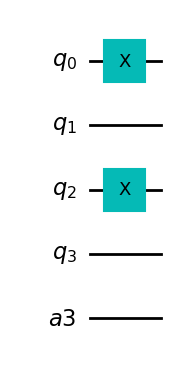

In [138]:
base_c.draw('mpl')

In [139]:
# Construct QuantumCircuit object serving as the MPF circuit:

mpf = base_c # Mulit-product Formula circuit

In [140]:
# Append appropriate unitary gates to MPF circuit:

mpf.append(V_k, [4])

In [141]:
# Append classical register to MPF circuit:

classical_reg = ClassicalRegister(1)

mpf.add_register(classical_reg)

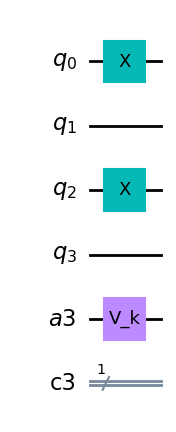

In [142]:
# Draw:

mpf.draw('mpl')

In [143]:
# Construct proper QuantumCircuit object for MPF:

MPF = QuantumCircuit(mpf.width() - 1)

In [144]:
# Append mpf to MPF circuit:

MPF = MPF.compose(mpf)

In [145]:
MPF.draw()

┌───┐ 
 q_0: ─┤ X ├─
       └───┘ 
 q_1: ───────
       ┌───┐ 
 q_2: ─┤ X ├─
       └───┘ 
 q_3: ───────
      ┌─────┐
 q_4: ┤ V_k ├
      └─────┘
c3: 1/═══════

In [146]:
# Append controlled unitary gates:

S1_circ = QuantumCircuit(4)

for i in range(len(S_1)):
    S1_circ = S1_circ.compose(S_1[i], range(4))

#S1_circ.bind_parameters({evo_time: 2})

In [147]:
print(S_1)

[Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[Parameter(t)]), Instruction(name='PauliEvolution', num_qub

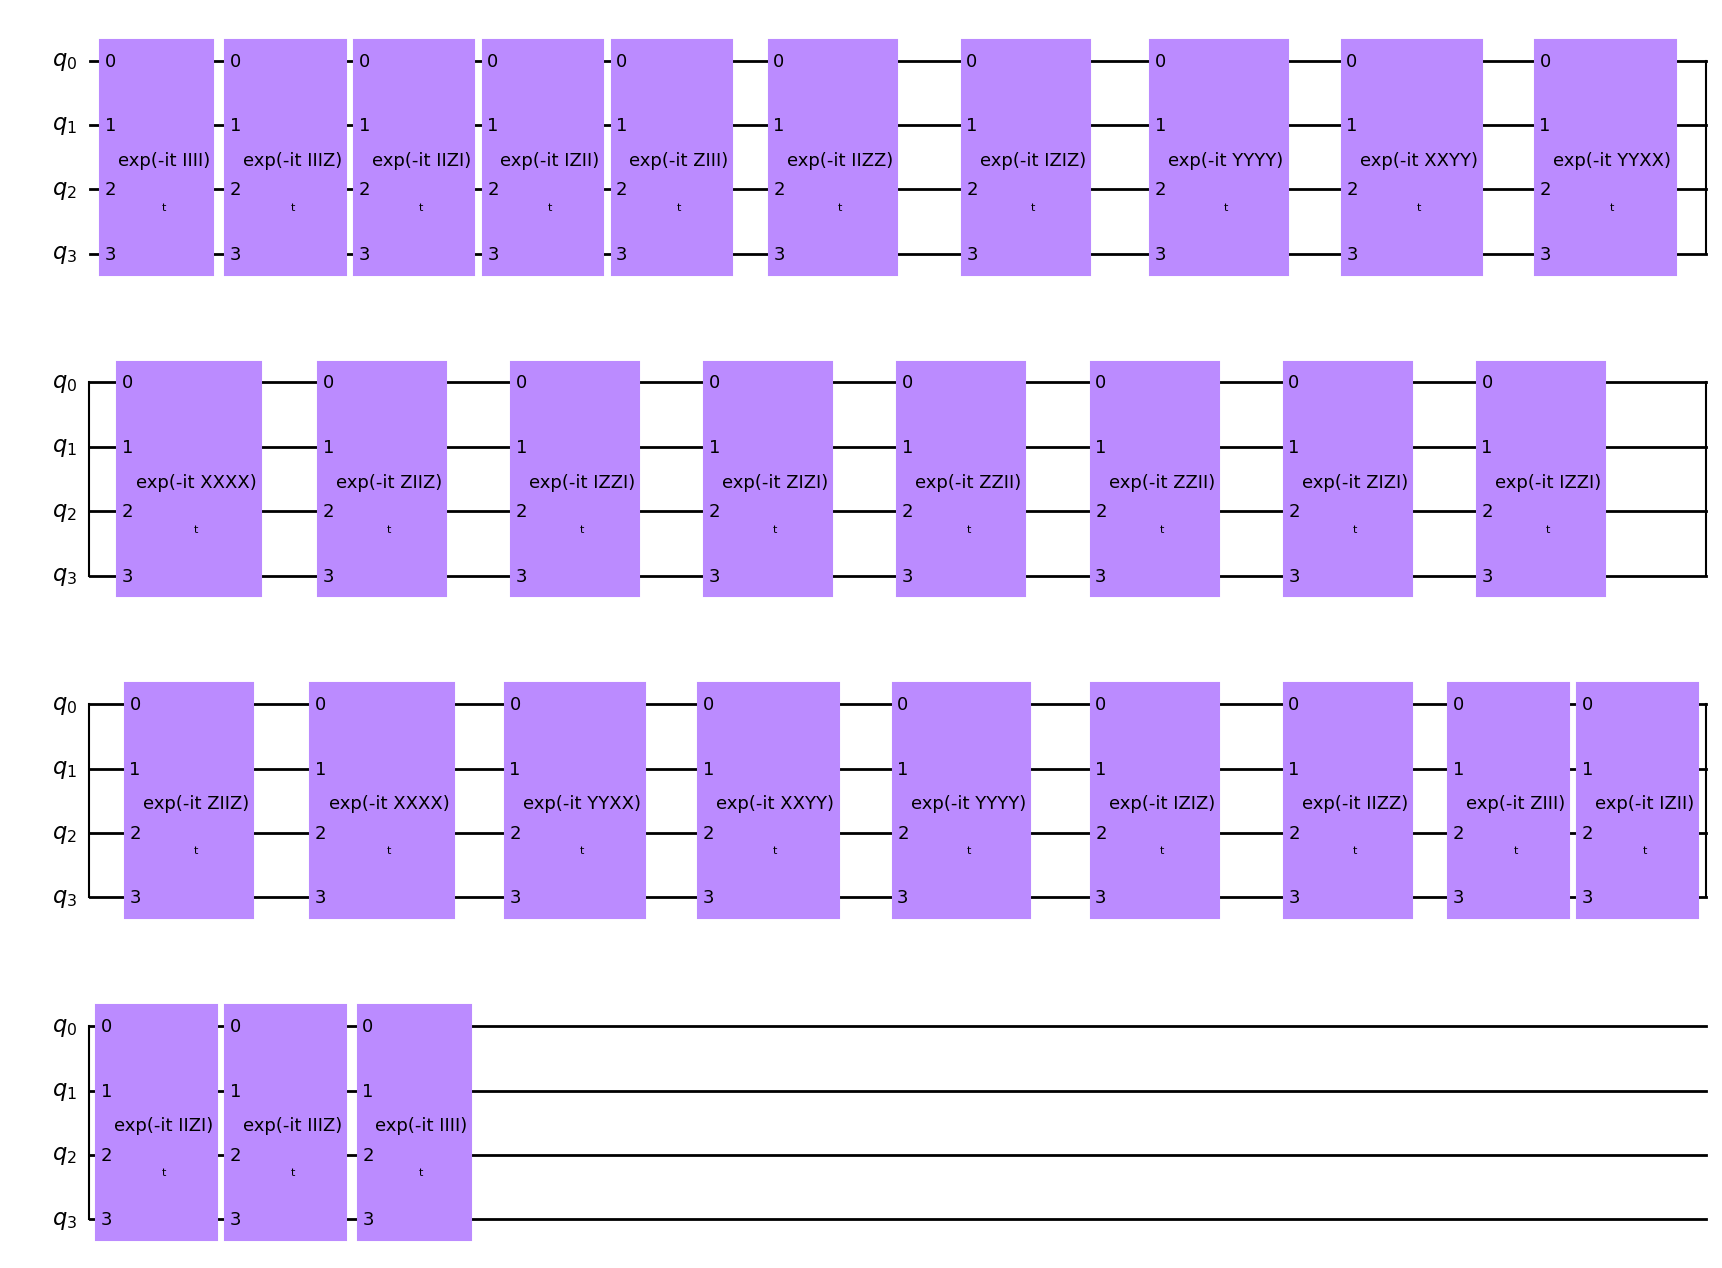

In [148]:
S1_circ.draw('mpl')

In [149]:
# Convert S_1 circuit to Gate:

S_1_gate = circuit_to_gate(S1_circ, label="S_1_gate")

In [150]:
# Repeat same processs for the S_1_lq instructions:

S1_lq_circ = QuantumCircuit(4)

for i in range(len(S_1)):
    S1_lq_circ = S1_lq_circ.compose(S_1_lq[i], range(4))

for i in range(len(S_1)):
    S1_lq_circ = S1_lq_circ.compose(S_1_lq[i], range(4))

#S1_lq_circ.bind_parameters({evo_time: evo_time_range[0]})

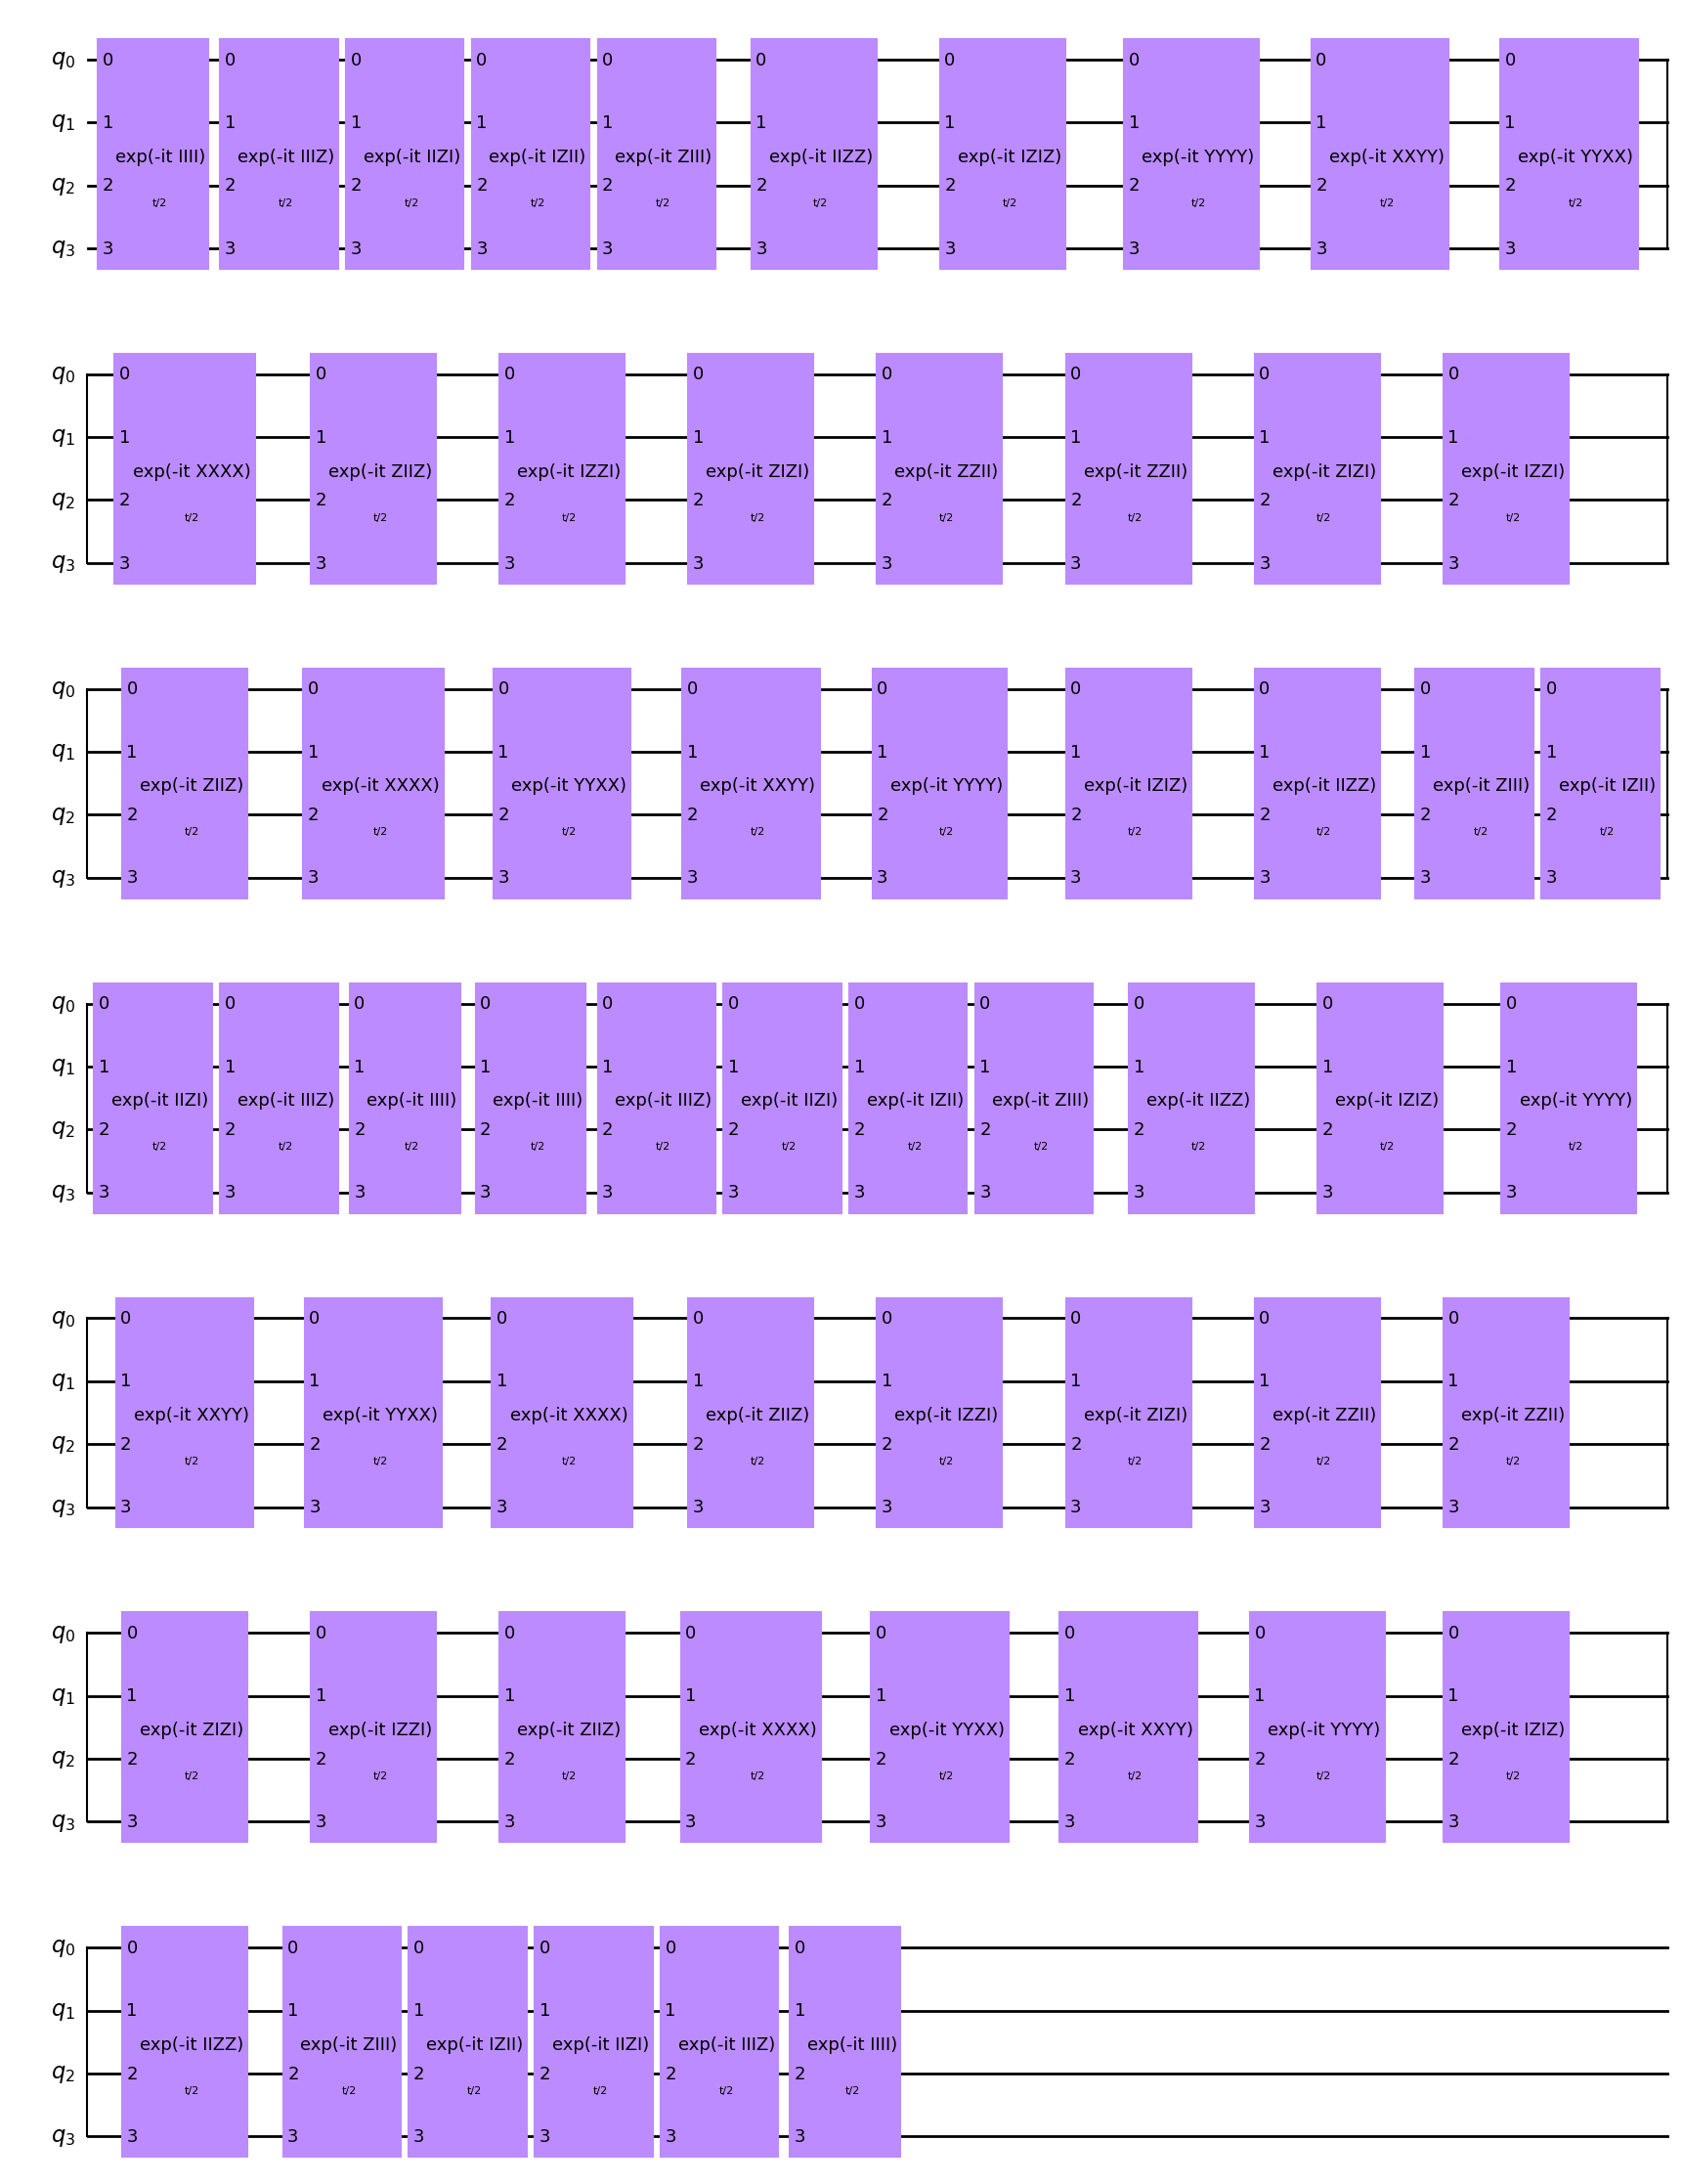

In [151]:
S1_lq_circ.draw('mpl')

In [152]:
# Convert S_1_lq circuit to Gate:

S_1_lq_gate = circuit_to_gate(S1_lq_circ, label="S_1_lq gate")

In [153]:
# Compose controlled versions of each unitary:

CS_1 = S_1_gate.control(1, label= "CS_1")

CS_1_lq = S_1_lq_gate.control(1, label= "CS_1_lq")


In [154]:
# Append Controlled Unitaries to MPF Circuit:

MPF.x([4])
MPF.append(CS_1, [4, 0, 1, 2, 3])
MPF.x([4])
MPF.append(CS_1_lq, [4, 0, 1, 2, 3])

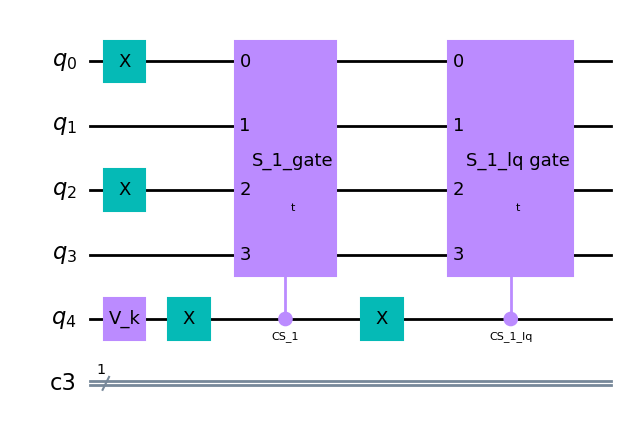

In [155]:
MPF.draw('mpl')

In [156]:
# Append remaining V_k gate to MPF circuit:

MPF.append(V_k, [4])

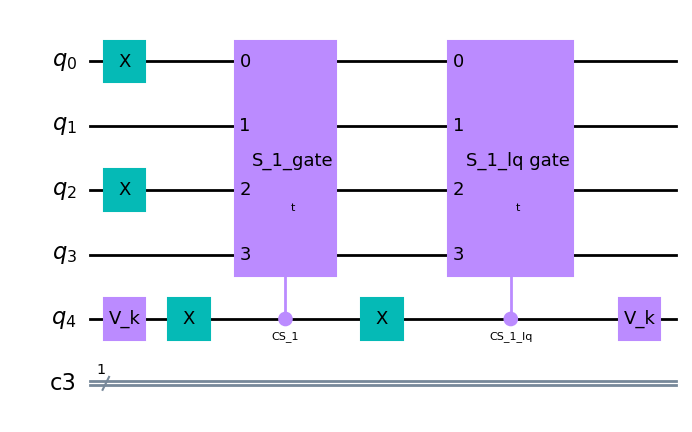

In [157]:
MPF.draw('mpl')

In [158]:
# Save the circuit:

#MPF.save_statevector()

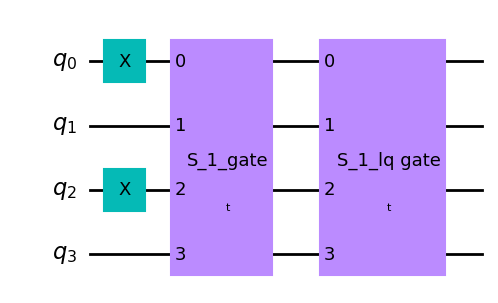

In [159]:
# Construct Time Evolution circuit independent of Ancilla:
'''Reasoning: The positive measurement of a 0 within the ancilla qubit will apply the split unitaries, allowing for proper time evolution;
algorithm failure means that there's no time evolution!'''

MPF_evo_circ = QuantumCircuit(initial_state_width)

MPF_evo_circ = MPF_evo_circ.compose(initial_state_copy)

MPF_evo_circ.append(S_1_gate, range(MPF_evo_circ.width()))

MPF_evo_circ.append(S_1_lq_gate, range(MPF_evo_circ.width()))

MPF_evo_circ.draw('mpl')

Multi-Product Formula Algorithm:

In [160]:
# Invoke simulator to perform measurement:

backend = Aer.get_backend('aer_simulator')


In [161]:
# Define two functions to obtain the expectation value and algorithm success boolean in one sweep:

def MPF_measure(MPF):

    MPF.measure([4], 0) # Perform a measurement on the ancilla qubit and project to the classical register

    MPF.draw('mpl')

    MPF = transpile(MPF, backend) # Transpile measured circuit

    result = backend.run(MPF, shots=1, memory=True).result() # Obtain result.

    if (result.get_memory(MPF) == ['1']):
        return("Failure!")
    else:
        return("Success!")

def MPF_algo(MPF, evo_circ):

    estimator = Estimator() # Invoke estimator to perform expectation value measurements

    result_message = MPF_measure(MPF) # Obtain resultant message

    if (result_message == "Failure!"):
        return ("Time Evolution not possible. Algorithm Failure.")
    else:

        energies = list() # Generate list to cache energies.

        for k in range(len(evo_time_range)): # Perform a Real Time Evolution of the MPF circuit.
            ev_result = estimator.run(evo_circ, qubit_h2_Ham, parameter_values=(evo_time_range[k])).result()
            energies.append(np.real(ev_result.values))

    return (energies)


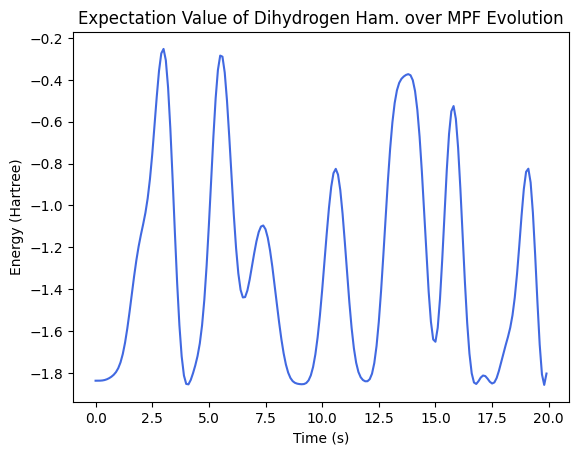

In [162]:
# Measure the Ancilla qubit. If the measurement is '0', then the algorithm is a success. Else, algorithm failed:

algo_result = MPF_algo(MPF, MPF_evo_circ)

if (algo_result != "Time Evolution not possible. Algorithm Failure."):

    plt.plot(evo_time_range, algo_result, color="royalblue")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (Hartree)")
    plt.title("Expectation Value of Dihydrogen Ham. over MPF Evolution")
    
else:
    print(algo_result)
